In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from typing import Tuple, List
import os
import re

In [3]:
import pandas as pd
from typing import Tuple
import re

def parse_filenames(df: pd.DataFrame) -> pd.DataFrame:
    """Processes a DataFrame to extract sample, sampler, and method from filenames.
    
    It reads from a column 'Unnamed: 0', and creates 'sample',
    'sampler', and 'method' columns, then drops the original column.

    Args:
        df: The input pandas DataFrame.

    Returns:
        A new DataFrame with the processed columns.
    """
    
    # Work on a copy to avoid side effects and SettingWithCopyWarning
    df_copy = df.copy()
    
    # The name of the column containing the filenames
    filename_col = 'Unnamed: 0'

    def parse_filename(filename: str) -> Tuple[str, str, str]:
        """Parses a filename to extract sample, sampler, and method.

        Handles formats like:
        - `debris_1_FMW_groupwise` -> sample: 1, sampler: FMW, method: groupwise
        - `flowmop_debris_2` -> sample: 2, sampler: flowmop, method: samplewise
        - `debris_1_null_debris_samplewise` -> sample: 1, sampler: RJ, method: samplewise

        Args:
            filename: The filename string to parse.

        Returns:
            A tuple containing the sample, sampler, and method.
        """
        
        # Clean the filename by removing the extension and any whitespace
        clean_name = filename.replace('.fcs', '').strip()
        parts = clean_name.split('_')
        
        sample, sampler, method = '', '', ''

        # Handle format: flowmop_debris_2
        if parts[0] == 'flowmop' and parts[1] == 'debris':
            sample = parts[2]
            sampler = parts[0]
            method = 'samplewise'
        # Handle debris formats
        elif parts[0] == 'debris' and len(parts) >= 4:
            sample = parts[1]
            if 'SC' in parts:
                sampler = 'SC'
                method = parts[-1]
            elif parts[2] == 'null':
                sampler = 'RJ'
                method = parts[-1] # e.g., groupwise or samplewise
            else:
                sampler = parts[2]
                method = parts[3]
            
        return sample, sampler, method

    # Apply the parsing function to the column to create new columns
    df_copy[['sample', 'sampler', 'method']] = df_copy[filename_col].apply(
        lambda name: pd.Series(parse_filename(name))
    )
    
    # Drop the original 'Unnamed: 0' column
    df_processed = df_copy.drop(columns=[filename_col])
    
    return df_processed

In [8]:
synth_dir = r"D:\github_remotes\FlowMOP\flowmop_paper\figs_data\fig_2_data\fig_2_analysis"
csvs = [f for f in os.listdir(synth_dir) if f.endswith('.csv')]
debris_data = [pd.read_csv(synth_dir + "\\" + csv) for csv in csvs if 'debris' in csv]
for i, debris in enumerate(debris_data): 
    debris_data[i] = debris_data[i][~debris_data[i]['Unnamed: 0'].str.contains('Mean', na=False)]
    debris_data[i] = debris_data[i][~debris_data[i]['Unnamed: 0'].str.contains('SD', na=False)]

for i, time in enumerate(debris_data): 
    debris_data[i] = parse_filenames(time).sort_values(by="sample").reset_index(drop=True)

overall_counts = debris_data[0]["Count"]
initial_sample = debris_data[0]["sample1 | Freq. of Parent (%)"]
debris_data[0]["Count"] = overall_counts * debris_data[0]["passeddebris subset | Freq. of Parent (%)"]/100

In [9]:
debris_data[0].drop(
    columns=["Unnamed: 7", "sample1 | Freq. of Parent (%)", 
             "sample2 | Freq. of Parent (%)", "passeddebris subset | Freq. of Parent (%)"], inplace=True)
debris_data[1].drop(columns=["Unnamed: 3"], inplace=True)
# Rename the columns as requested
debris_data[0] = debris_data[0].rename(columns={
    'passeddebris subset/sample1 | Freq. of Parent (%)': 'debris',
    'passeddebris subset/sample2 | Freq. of Parent (%)': 'clean'
})
debris_data[1] = debris_data[1].rename(columns={
    '1 | Freq. of Parent (%)': 'debris',
    '2 | Freq. of Parent (%)': 'clean',
})


combined_debris = pd.concat([debris_data[0], debris_data[1]])
combined_debris["removed_debris"] = 100 - combined_debris["debris"]
combined_debris_samplewise = combined_debris[combined_debris["method"] == "samplewise"]
combined_debris_groupwise = combined_debris[combined_debris["method"] == "groupwise"]

In [10]:
flowmop_data = combined_debris[combined_debris['sampler'] == 'flowmop']
from scipy import stats

# Perform paired t-test between initial_sample and flowmop_data debris
t_stat, p_value = stats.ttest_rel(initial_sample, flowmop_data['debris'])

print(f"Paired t-test results:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Print summary statistics for context
print(f"\nSummary statistics:")
print(f"Initial sample mean: {initial_sample.mean():.2f}")
print(f"FlowMOP debris mean: {flowmop_data['debris'].mean():.2f}")
print(f"Initial sample std: {initial_sample.std():.2f}")
print(f"FlowMOP debris std: {flowmop_data['debris'].std():.2f}")

Paired t-test results:
t-statistic: 34.3313
p-value: 0.0008

Summary statistics:
Initial sample mean: 50.63
FlowMOP debris mean: 28.80
Initial sample std: 1.10
FlowMOP debris std: 0.10


C:\Users\xuton\AppData\Local\Temp\ipykernel_27728\435960815.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\xuton\AppData\Local\Temp\ipykernel_27728\435960815.py:48: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


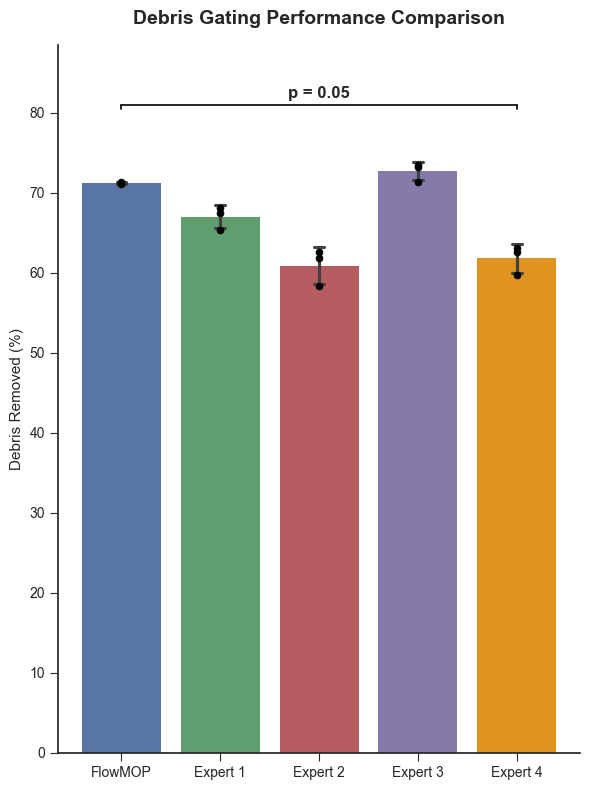

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# --- Data Preparation (same as before) ---
anonymize_map = {
    'flowmop': 'FlowMOP',
    'FMW': 'Expert 1',
    'NR': 'Expert 3',
    'RJ': 'Expert 4',
    'SC': 'Expert 2',
}
plot_df = combined_debris_samplewise.copy()
plot_df['sampler_anonymized'] = plot_df['sampler'].map(anonymize_map)

# Paired t-test data
flowmop_scores = plot_df[plot_df['sampler_anonymized'] == 'FlowMOP'].sort_values('sample')['removed_debris']
p_values = {}
for expert in ['Expert 1', 'Expert 2', 'Expert 3', 'Expert 4']:
    expert_scores = plot_df[plot_df['sampler_anonymized'] == expert].sort_values('sample')['removed_debris']
    t_stat, p_val = stats.ttest_rel(flowmop_scores, expert_scores)
    p_values[expert] = p_val
n_tests = len(p_values)

# --- Publication-Style Plotting with Significance Connectors ---

# 1. Use a cleaner style and adjust figure size for vertical orientation
plt.style.use('seaborn-v0_8-ticks')
fig, ax = plt.subplots(figsize=(6, 8))

order = ['FlowMOP', 'Expert 1', 'Expert 2', 'Expert 3', 'Expert 4']
palette = ['#4c72b0', '#55a868', '#c44e52', '#8172b2', '#ff9900']

# 2. Bar plot with standard deviation error bars (vertical orientation)
sns.barplot(
    x='sampler_anonymized',
    y='removed_debris',
    data=plot_df,
    order=order,
    palette=palette,
    errorbar='sd',
    capsize=0.1,
    ax=ax
)

# 3. Stripplot for individual data points (vertical orientation)
sns.stripplot(
    x='sampler_anonymized',
    y='removed_debris',
    data=plot_df,
    order=order,
    color='black',
    size=5,
    jitter=0,
    ax=ax,
    edgecolor='gray',
    linewidth=0.5
)

# 4. Refine titles and labels
ax.set_title('Debris Gating Performance Comparison', fontsize=14, weight='bold', pad=15)
ax.set_xlabel('')
ax.set_ylabel('Debris Removed (%)', fontsize=11)
ax.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

# 5. Add significance annotations with connecting bars (adjusted for vertical orientation)

# Helper function for formatting p-values (consistent with fig_2_time.ipynb)
def format_p_value(p):
    if p < 0.001:
        return "p < 0.001"
    elif p < 0.01:
        return f"p = {p:.3f}"
    else:  # p-values between 0.01 and 0.05
        return f"p = {p:.2f}"

def add_significance_bar(x1, x2, p_corrected, y_pos, ax):
    """Draws a significance bar between two x-levels if p < 0.05."""
    if p_corrected >= 0.05:
        return

    tick_len = 0.5

    # Draw horizontal connector
    ax.plot([x1, x2], [y_pos, y_pos], c='k', lw=1.2)
    # Draw left vertical tick
    ax.plot([x1, x1], [y_pos - tick_len, y_pos], c='k', lw=1.2)
    # Draw right vertical tick
    ax.plot([x2, x2], [y_pos - tick_len, y_pos], c='k', lw=1.2)

    # Add p-value text instead of asterisks
    ax.text(
        (x1 + x2) / 2,
        y_pos + tick_len,
        format_p_value(p_corrected),
        va='bottom',
        ha='center',
        fontsize=12,
        weight='bold',
    )


# Calculate position for annotation bars to be above the plot
max_y = 0
for p in ax.patches:
    mean_val = p.get_height()
    # Find std for the corresponding group
    group_name = order[int(p.get_x())]
    std_val = plot_df[plot_df['sampler_anonymized'] == group_name]['removed_debris'].std()
    max_y = max(max_y, mean_val + std_val)

bar_y_pos = max_y * 1.08  # Start position for the first annotation
y_increment = max_y * 0.1 # Space between subsequent annotations

x_flowmop = order.index('FlowMOP')
for expert in order[1:]:
    p_corrected = min(p_values[expert] * n_tests, 1.0)
    if p_corrected < 0.05:
        x_expert = order.index(expert)
        add_significance_bar(x_flowmop, x_expert, p_corrected, bar_y_pos, ax)
        bar_y_pos += y_increment # Move next bar up

# Adjust plot limits and layout
ax.set_ylim(top=bar_y_pos)
plt.tight_layout()
plt.show()


In [40]:
combined_debris

,debris,clean,Count,sample,sampler,method,removed_debris
0,28.7,71.3,22029.754,1,flowmop,samplewise,71.3
1,28.9,71.1,26380.242,2,flowmop,samplewise,71.1
2,28.8,71.2,22097.250,3,flowmop,samplewise,71.2
0,32.5,67.5,NaN,1,FMW,samplewise,67.5
1,37.5,62.5,NaN,1,SC,groupwise,62.5
2,26.5,73.5,NaN,1,NR,samplewise,73.5
3,37.3,62.7,NaN,1,RJ,groupwise,62.7
4,36.9,63.1,NaN,1,RJ,samplewise,63.1
5,26.7,73.3,NaN,1,NR,groupwise,73.3
6,37.4,62.6,NaN,1,SC,samplewise,62.6


In [45]:
(combined_debris.loc[combined_debris["sampler"] == "flowmop", "removed_debris"].mean() - combined_debris.loc[combined_debris["sampler"] == "RJ", "removed_debris"].mean())/0.5

19.333333333333314

61.53333333333333

C:\Users\Tony\AppData\Local\Temp\ipykernel_58868\2411201996.py:63: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(
C:\Users\Tony\AppData\Local\Temp\ipykernel_58868\2411201996.py:63: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


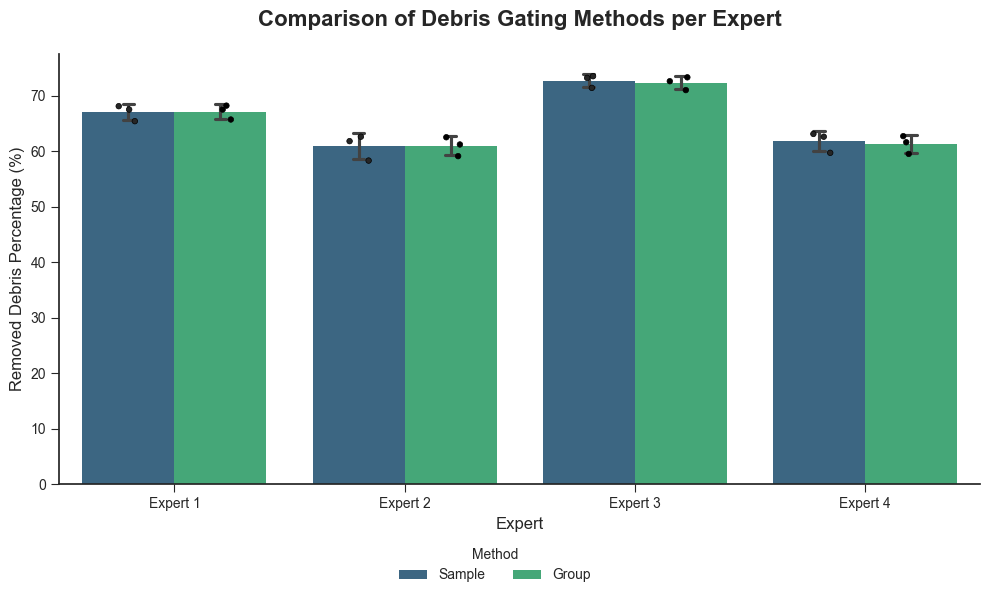

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd

# 1. Data Preparation
# Filter for human experts and create a copy to avoid SettingWithCopyWarning
experts_df = combined_debris[combined_debris['sampler'] != 'flowmop'].copy()

# Anonymize sampler names
anonymize_map = {
    'FMW': 'Expert 1',
    'NR': 'Expert 3',
    'RJ': 'Expert 4',
    'SC': 'Expert 2'
    
}
experts_df['sampler_anonymized'] = experts_df['sampler'].map(anonymize_map)

# Capitalize method names for a cleaner legend in the plot
experts_df['method'] = experts_df['method'].str.replace('wise', '').str.capitalize()

# 2. Paired T-tests
# Compare 'groupwise' vs 'samplewise' for each expert
p_values_method_comparison = {}
experts = ['Expert 1', 'Expert 2', 'Expert 3', 'Expert 4']

for expert in experts:
    expert_df = experts_df[experts_df['sampler_anonymized'] == expert]
    
    # Ensure the data is sorted by sample to correctly pair the measurements
    groupwise_scores = expert_df[expert_df['method'] == 'Group'].sort_values('sample')['removed_debris']
    samplewise_scores = expert_df[expert_df['method'] == 'Sample'].sort_values('sample')['removed_debris']
    
    # The lengths of the series must be equal for a paired t-test
    if len(groupwise_scores) == len(samplewise_scores) and len(groupwise_scores) > 0:
        t_stat, p_val = stats.ttest_rel(groupwise_scores, samplewise_scores)
        p_values_method_comparison[expert] = p_val
    else:
        print(f"Could not perform t-test for {expert}: unequal number of samples or no samples.")
        p_values_method_comparison[expert] = 1.0 # Assign a non-significant p-value

# 3. Create the Plot
plt.style.use('seaborn-v0_8-ticks')
fig, ax = plt.subplots(figsize=(10, 6))

order = ['Expert 1', 'Expert 2', 'Expert 3', 'Expert 4']
# Create the grouped bar plot
sns.barplot(
    x='sampler_anonymized', 
    y='removed_debris', 
    hue='method', 
    data=experts_df, 
    order=order,
    palette='viridis',
    errorbar='sd',
    capsize=0.1,
    ax=ax
)

# Overlay individual data points
sns.stripplot(
    x='sampler_anonymized',
    y='removed_debris',
    hue='method',
    data=experts_df,
    order=order,
    dodge=True,
    color='black',
    size=4,
    jitter=0.1,
    ax=ax,
    edgecolor='gray',
    linewidth=0.5
)

# 4. Add Significance Annotations
def add_significance_bracket(x_center, p_val, ax, experts_df, order):
    """Draws a significance bracket over a group of bars."""
    if p_val >= 0.05:
        return

    if p_val < 0.001:
        s_text = '***'
    elif p_val < 0.01:
        s_text = '**'
    else:
        s_text = '*'
    
    # Determine the top of the bars for the current group to place the bracket
    expert_name = order[int(round(x_center))]
    group_data = experts_df[experts_df['sampler_anonymized'] == expert_name]
    
    # Calculate the mean + std dev for both methods to find the highest point
    max_y = 0
    for method in ['Group', 'Sample']:
        method_data = group_data[group_data['method'] == method]['removed_debris']
        if not method_data.empty:
            mean_val = method_data.mean()
            std_val = method_data.std()
            max_y = max(max_y, mean_val + std_val)

    bar_width = 0.4
    x1 = x_center - bar_width / 2
    x2 = x_center + bar_width / 2
    
    # Position the bracket slightly above the highest bar/error bar
    y_bracket = max_y + 0.05 * ax.get_ylim()[1]
    bracket_height = 0.02 * ax.get_ylim()[1]
    
    ax.plot([x1, x1, x2, x2], [y_bracket, y_bracket + bracket_height, y_bracket + bracket_height, y_bracket], c='k', lw=1.2)
    ax.text((x1 + x2) / 2, y_bracket + bracket_height, s_text,
            ha='center', va='bottom', fontsize=12, weight='bold')

# Add annotations for each expert
for i, expert in enumerate(order):
    if expert in p_values_method_comparison:
        p_val = p_values_method_comparison[expert]
        add_significance_bracket(i, p_val, ax, experts_df, order)

# 5. Final Touches
ax.set_title('Comparison of Debris Gating Methods per Expert', fontsize=16, weight='bold', pad=20)
ax.set_xlabel('Expert', fontsize=12)
ax.set_ylabel('Removed Debris Percentage (%)', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)

# Get handles and labels, then remove the default legend
handles, labels = ax.get_legend_handles_labels()
if ax.get_legend() is not None:
    ax.get_legend().remove()

# Add a new legend at the bottom of the figure
fig.legend(
    handles[:2], 
    labels[:2], 
    title='Method', 
    bbox_to_anchor=(0.5, 0), 
    loc='lower center', 
    ncol=2, 
    frameon=False
)

sns.despine()

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()

In [ ]:
grep -rl --exclude-dir=.git '_RJ_' . | xargs sed -i 's/_RJ_/_expertiv/g'